# Abstract
## Purpose & Motivation

While going through the visualization, we have seen a bunch of different stations that don't make sense given the values found. Some stations look like they are misclassified, while others have incorrect lat/lon or number of lanes.

The goal is to create an algorithmic approach to identify potential issues within the data and then see if this can be corrected in a manner that makes sense given our domain knowledge of the San Diego traffic system.

Note: this code requires spark 2.0+

Once the data is cleaned analysis will be conducted to see if we can visually detect syncronized flow by using a plotting approach found during the research phase.

## Direction from Advisor
Abandon this research

## Tasks/Questions to Answer
### Questions to Answer
* How sensitive is the data to the raw % observed and how might this impact our calculations
* How many stations are potentially misclassified

### Tasks
* Explore changes in flow rates based upon % observed filtering
* Identify how to justify misclassified stations and then identify how to correct
* Attempt to fix misclassified stations

## Conclusions
* The data does appear to be very sensitive the the % observed data since it can change the flow seen in a particular freeway subsection by 10x. At an aggregate level is probably wouldn't be noticed, but in small sections 10x changes can be seen.
* An isolation forest was fairly successful in identifying outliers (additional tuning may be required)
* No further conclusions due to abandoning this research


In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Import data types
from pyspark.sql.types import *
from pyspark.sql.functions import minute, hour, concat, col, lit, Column

# sparkConf = SparkConf()
# sparkConf.set("spark.ui.port", "4050")

#     .config("spark.driver.allowMultipleContexts", "true") \

# spark = SparkSession \
#     .builder \
#     .appName("moreTrafficData") \
#     .getOrCreate()

In [104]:
import pandas as pd
from time import time
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.ensemble
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble.iforest import IsolationForest
from sklearn.preprocessing import LabelEncoder
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

# Load Metadata

In [3]:
!head -n 5 ../../data/meta_2015_with_elev.csv

,Unnamed: 0,Unnamed: 0.1,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,0,0,1113072,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,0.452,ML,2,Black Mountain Rd,314,,,,2015_01_01,178.243728638
1,1,1,1113073,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,OR,3,BLACK MOUNTAIN RD,314,,,,2015_01_01,178.243728638
2,2,2,1113680,56,E,11,73,66000.0,6.862,7.364,32.953394,-117.133404,0.999,ML,3,BLACK MOUNTAIN RD,434,,,,2015_01_01,150.936233521
3,3,3,1113683,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,FR,2,BLK MOUNTAIN - WB 56,314,,,,2015_01_01,178.243728638


In [50]:
# loaded the data using spark (for fun...)
meta_data = spark.read.csv('../../data/meta_2015_with_elev.csv',
                           inferSchema='true',
                           header='true',
                           sep=',',
                           encoding='utf-8',
                           timestampFormat='MM/dd/yyyy HH:mm:ss',
                         )

In [14]:
# # drop unnecessary columns
# meta_data = meta_data.drop('Unnamed: 0',
#                            'Unnamed: 0.1',
#                            'User_ID_1',
#                            'User_ID_2',
#                            'User_ID_3',
#                            'User_ID_4')

In [51]:
meta_df = meta_data.toPandas()

In [52]:
meta_df[meta_df.ID == 1122588]

,_c0,Unnamed: 0,Unnamed: 0.1,ID,Fwy,Dir,District,County,City,State_PM,...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
1348,1348,1348,1348,1122588,5,N,11,73,66000.0,R20.702,...,NaN,FR,1,5 NB S/O Sea World,26202,None,None,None,2015_12_17,5.071532


In [53]:
def create_freeway_vectors(frame_to_use, columns_to_select=['ID', 'Latitude', 'Longitude', 'Abs_PM', 'Lanes']):
    to_loop = frame_to_use.groupby(['Fwy', 'Dir'])['ID'].count().reset_index()[['Fwy', 'Dir']].values
    
    ret = {}
    for Fwy, Dir in to_loop:
        tmp = frame_to_use[(frame_to_use.Fwy == Fwy) & (frame_to_use.Dir == Dir)
                                                  & (frame_to_use.Type == 'ML')]\
            .sort_values(by='Abs_PM', ascending=True)[columns_to_select].drop_duplicates()
        tmp['order'] = pd.Series(index=tmp.index, data=sorted(range(0, len(tmp.ID)), reverse=False))
        tmp['distance'] = tmp.Abs_PM - tmp.Abs_PM.shift(1)        
        tmp.loc[tmp['order'] == 0, 'distance'] = tmp[tmp['order'] == 0].Abs_PM
        ret["%s_%s" % (Fwy, Dir)] = tmp
    return ret 

In [54]:
freeway_vectors = create_freeway_vectors(meta_df)

In [210]:
# freeway_vectors['56_W']

In [20]:
# meta_data.take(1)

# Load 5 Minute Data
## Create the schema

In [42]:
struct_list = [
   StructField("timestamp",TimestampType(),True),
   StructField("station",IntegerType(),True),
   StructField("district",IntegerType(),True),
   StructField("freeway",IntegerType(),True),
   StructField("direction_of_travel",StringType(),True),
   StructField("lanetype",StringType(),True),
   StructField("stationlength",DoubleType(),True),
   StructField("samples",IntegerType(),True),
   StructField("perc_observed",IntegerType(),True),
   StructField("totalflow",IntegerType(),True),
   StructField("avgoccupancy",DoubleType(),True),
   StructField("avgspeed",DoubleType(),True),
   StructField("lane1_samples",IntegerType(),True),
   StructField("lane1_flow",IntegerType(),True),
   StructField("lane1_avgocc",DoubleType(),True),
   StructField("lane1_avgspeed",DoubleType(),True),
   StructField("lane1_observed",IntegerType(),True),
   StructField("lane2_samples",IntegerType(),True),
   StructField("lane2_flow",IntegerType(),True),
   StructField("lane2_avgocc",DoubleType(),True),
   StructField("lane2_avgspeed",DoubleType(),True),
   StructField("lane2_observed",IntegerType(),True),
   StructField("lane3_samples",IntegerType(),True),
   StructField("lane3_flow",IntegerType(),True),
   StructField("lane3_avgocc",DoubleType(),True),
   StructField("lane3_avgspeed",DoubleType(),True),
   StructField("lane3_observed",IntegerType(),True),
   StructField("lane4_samples",IntegerType(),True),
   StructField("lane4_flow",IntegerType(),True),
   StructField("lane4_avgocc",DoubleType(),True),
   StructField("lane4_avgspeed",DoubleType(),True),
   StructField("lane4_observed",IntegerType(),True),
   StructField("lane5_samples",IntegerType(),True),
   StructField("lane5_flow",IntegerType(),True),
   StructField("lane5_avgocc",DoubleType(),True),
   StructField("lane5_avgspeed",DoubleType(),True),
   StructField("lane5_observed",IntegerType(),True),
   StructField("lane6_samples",IntegerType(),True),
   StructField("lane6_flow",IntegerType(),True),
   StructField("lane6_avgocc",DoubleType(),True),
   StructField("lane6_avgspeed",DoubleType(),True),
   StructField("lane6_observed",IntegerType(),True),
   StructField("lane7_samples",IntegerType(),True),
   StructField("lane7_flow",IntegerType(),True),
   StructField("lane7_avgocc",DoubleType(),True),
   StructField("lane7_avgspeed",DoubleType(),True),
   StructField("lane7_observed",IntegerType(),True),
   StructField("lane8_samples",IntegerType(),True),
   StructField("lane8_flow",IntegerType(),True),
   StructField("lane8_avgocc",DoubleType(),True),
   StructField("lane8_avgspeed",DoubleType(),True),
   StructField("lane8_observed",IntegerType(),True)
]
schema = StructType(struct_list)

## Read Data

In [43]:
# path to the 5min data files
# !ls ../../../../cohort2/output/station_5min/2015/d11

In [44]:
# review the file
single_file = '../../../../cohort2/output/station_5min/2015/d11/d11_text_station_5min_2015_01_01.txt.gz'
all_files = '../../../../cohort2/output/station_5min/2015/d11/*.txt.gz'
# first_file = sc.textFile(single_file)
# first_file.take(1)

In [179]:
# start_time = time()
# data = spark.read.csv(all_files,
#                       inferSchema='false',
#                       schema=schema,
#                       sep=',',
#                       encoding='utf-8',
#                       timestampFormat='MM/dd/yyyy HH:mm:ss',
#                      )
# # data = spark.read.csv(all_files, schema=schema, sep=',', encoding='utf-8')

# # convert timestamp to time only column
# data = (data
#         .withColumn("minute", minute(data['Timestamp']).cast("int"))
#         .withColumn("hour", hour(data['Timestamp']).cast("int")))
# # tmp = data.first()
# # print tmp
# # print type(tmp.hour)

# data = (data
#         .withColumn('Time', concat(data.hour, lit(":"), data.minute))
#         .withColumn('TimeNumber', data.hour * 12 + data.minute/5))
# # data = (data.withColumn('Time', data['hour'] + ':' + data['minute']))

# # print data.take(1)

# # Creates a temporary view using the DataFrame
# # data.createOrReplaceTempView("data")

# # SQL can be run over DataFrames that have been registered as a table.
# # results = spark.sql("SELECT count(Station) as cnt FROM data")

# # results.show()

# result_by_time = data.groupBy(['Station', 'TimeNumber']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()
# # filter to 5:00 am to 9:00 pm to account for the stations that go offline during the evening.
# # result_avg = data.filter((21 >= data.hour) & (data.hour >= 5)).groupBy(['Station']).agg(    
# filtered_data = data.filter((21 >= data.hour) & (data.hour >= 5)).cache()
# result_avg_100 = filtered_data.filter((data.perc_observed >= 100))\
#     .groupBy(['Station']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()
# result_avg_80 = filtered_data.filter((data.perc_observed >= 80))\
#     .groupBy(['Station']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()     
# result_avg_50 = filtered_data.filter((data.perc_observed >= 50))\
#     .groupBy(['Station']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()
# result_avg = filtered_data.groupBy(['Station']).agg(
#     {'totalflow': 'mean',
#      'avgspeed': 'mean',
#      'perc_observed': 'mean',
#      'samples': 'mean',
#      'lane1_flow': 'mean',
#      'lane1_avgspeed': 'mean',
#      'lane2_flow': 'mean',
#      'lane2_avgspeed': 'mean',     
#      'lane3_flow': 'mean',
#      'lane3_avgspeed': 'mean',     
#      'lane4_flow': 'mean',
#      'lane4_avgspeed': 'mean',     
#      'lane5_flow': 'mean',
#      'lane5_avgspeed': 'mean',
#      'lane6_flow': 'mean',
#      'lane6_avgspeed': 'mean',     
#      'lane7_flow': 'mean',
#      'lane7_avgspeed': 'mean',     
#      'lane8_flow': 'mean',
#      'lane8_avgspeed': 'mean'}).toPandas()     
# print "total time: %s" % (time() - start_time)

total time: 2780.72991109


Using 2 cores it'll take 4180 seconds to process the two dataframes

### TODO: consider adding lane % observed

## Explore the Data
Observations:
* Data for each hour varies across even a single day
* The values for flow when no samples are records can be over 2x off
* The metadata includes 1541 stations in D11 (San Diego) yet not all of them have data for each day

### Distribution of Types of stations

| Lane Type | Count of Station | Lane Type Full Name |
|-----------|------------------|---------------------|
| ML        | 839              | Mainline
| OR        | 312              | On Ramp
| FR        | 234              | Off Ramp
| HV        | 93               | HOV
| FF        | 55               | Fwy-Fwy connector
| CH        | 7                | Conventional Highway
| CD        | 1                | Collector/Distributor

Note: The number of on ramps is 33% higher than the number of off ramps, which means that unless the off ramps have more lanes, the D11 inflow capacity exceeds the D11 out flow capacity

In [180]:
# # sort the columns
# result_avg_100 = result_avg_100.reindex_axis(sorted(result_avg_100.columns), axis=1)
# result_avg_80 = result_avg_80.reindex_axis(sorted(result_avg_80.columns), axis=1)
# result_avg_50 = result_avg_50.reindex_axis(sorted(result_avg_50.columns), axis=1)
# result_avg = result_avg.reindex_axis(sorted(result_avg.columns), axis=1)
# result_by_time = result_by_time.reindex_axis(sorted(result_by_time.columns), axis=1)

In [181]:
# merged_result_avg_100 = pd.merge(result_avg_100, meta_df, how='left', left_on='Station', right_on='ID')
# merged_result_avg_80 = pd.merge(result_avg_80, meta_df, how='left', left_on='Station', right_on='ID')
# merged_result_avg_50 = pd.merge(result_avg_50, meta_df, how='left', left_on='Station', right_on='ID')
# merged_result_avg = pd.merge(result_avg, meta_df, how='left', left_on='Station', right_on='ID')
# result_by_time = pd.merge(result_by_time, meta_df, how='left', left_on='Station', right_on='ID')

In [182]:
# # export the data files
# merged_result_avg_100.to_csv('../../data/merged_result_avg_100.csv')
# merged_result_avg_80.to_csv('../../data/merged_result_avg_80.csv')
# merged_result_avg_50.to_csv('../../data/merged_result_avg_50.csv')
# merged_result_avg.to_csv('../../data/merged_result_avg.csv')
# result_by_time.to_csv('../../data/result_by_time.csv')

## Read final csv

In [184]:
merged_result_avg_100 = pd.read_csv('../../data/merged_result_avg_100.csv')
merged_result_avg_80 = pd.read_csv('../../data/merged_result_avg_80.csv')
merged_result_avg_50 = pd.read_csv('../../data/merged_result_avg_50.csv')
merged_result_avg = pd.read_csv('../../data/merged_result_avg.csv')
result_by_time = pd.read_csv('../../data/result_by_time.csv')

In [6]:
ret = merged_result_avg_100[merged_result_avg_100['avg(samples)'] < 5]
print "# of stations that have less than an average of 5 samples per 5 minutes: %s" % len(ret)
# ret

# of stations that have less than an average of 5 samples per 5 minutes: 1


## Review the aggregate flow for a single freeway
The assumption is that analyzing the flow through the traffic system will lead to insights about the data. We will compare the total flow through the freeways compared to the inflow and outflow to see if this data can lead to a meaningful model.

In [59]:
# Let's look at a single freeway / direction, ie: 56 W
W_56_100 = merged_result_avg_100[(merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56)]
print W_56_100.Lanes.unique()

W_56_80 = merged_result_avg_80[(merged_result_avg_80.Dir == 'W') & (merged_result_avg_80.Fwy == 56)]
print W_56_80.Lanes.unique()

W_56_50 = merged_result_avg_50[(merged_result_avg_50.Dir == 'W') & (merged_result_avg_50.Fwy == 56)]
print W_56_50.Lanes.unique()

W_56 = merged_result_avg[(merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56)]
print W_56.Lanes.unique()

[2 3 4 1]
[2 3 4 1]
[2 3 4 1]
[2 3 4 1]


In [60]:
W_56_100.groupby('Type').count()

,Unnamed: 0,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),...,Longitude,Length,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
Type,,,,,,,,,,,,,,,,,,,,,
FR,4,4,0,0,4,0,2,0,0,0,...,4,0,4,4,4,0,0,0,4,4
ML,9,9,9,9,9,9,9,0,0,0,...,9,9,9,9,9,0,0,0,9,9
OR,5,5,0,0,5,0,4,0,1,0,...,5,0,5,5,5,0,0,0,5,5


In [61]:
W_56_80.groupby('Type').count()

,Unnamed: 0,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),...,Longitude,Length,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
Type,,,,,,,,,,,,,,,,,,,,,
FR,4,4,0,0,4,0,2,0,0,0,...,4,0,4,4,4,0,0,0,4,4
ML,9,9,9,9,9,9,9,0,0,0,...,9,9,9,9,9,0,0,0,9,9
OR,5,5,0,0,5,0,4,0,1,0,...,5,0,5,5,5,0,0,0,5,5


In [62]:
W_56_50.groupby('Type').count()

,Unnamed: 0,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),...,Longitude,Length,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
Type,,,,,,,,,,,,,,,,,,,,,
FR,5,5,0,0,5,0,2,0,0,0,...,5,0,5,5,5,0,0,0,5,5
ML,10,10,10,10,10,10,10,0,0,0,...,10,10,10,10,10,0,0,0,10,10
OR,5,5,0,0,5,0,4,0,1,0,...,5,0,5,5,5,0,0,0,5,5


In [63]:
W_56.groupby('Type').count()

,Unnamed: 0,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),...,Longitude,Length,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
Type,,,,,,,,,,,,,,,,,,,,,
FR,6,6,0,0,5,0,2,0,0,0,...,6,0,6,6,6,0,0,0,6,6
ML,12,12,12,12,12,12,12,0,0,0,...,12,12,12,12,12,0,0,0,12,12
OR,6,6,0,0,5,0,4,0,1,0,...,6,0,6,6,6,0,0,0,6,6


In [71]:
W_56_in_flow = []
for key, data in zip(['100', '80', '50', 'all'], [W_56_100, W_56_80, W_56_50, W_56]):
    OR_W_56 = data[(data.Type == 'OR')].sort_values(by='Abs_PM', ascending=False)[
        ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
         'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)',
         'Latitude', 'Longitude']]
    W_56_in_flow_value = OR_W_56['avg(totalflow)'].sum()
    print "the in flow into 56_W for %s: %s" % (key, W_56_in_flow_value)
    W_56_in_flow.append(W_56_in_flow_value)
    OR_W_56

the total flow into 56_W for 100: 149.020134614
the total flow into 56_W for 80: 149.020134614
the total flow into 56_W for 50: 149.020134614
the total flow into 56_W for all: 149.020134614


In [72]:
W_56_out_flow = []
for key, data in zip(['100', '80', '50', 'all'], [W_56_100, W_56_80, W_56_50, W_56]):
    FR_W_56 = data[(data.Type == 'FR')].sort_values(by='Abs_PM', ascending=False)[
        ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
         'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)',
         'Latitude', 'Longitude']]
    W_56_out_flow_value = FR_W_56['avg(totalflow)'].sum()
    print "the out flow into 56_W for %s: %s" % (key, W_56_out_flow_value)
    W_56_out_flow.append(W_56_out_flow_value)
    FR_W_56

the out flow into 56_W for 100: 78.9074103103
the out flow into 56_W for 80: 78.9074103103
the out flow into 56_W for 50: 90.6333084912
the out flow into 56_W for all: 90.6333084912


In [74]:
W_56_thru_flow = []
for key, data in zip(['100', '80', '50', 'all'], [W_56_100, W_56_80, W_56_50, W_56]):
    ML_W_56 = data[(data.Type == 'ML')].sort_values(by='Abs_PM', ascending=False)[
        ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)',
         'avg(totalflow)', 'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)',
         'Latitude', 'Longitude']]
    W_56_thru_flow_value = ML_W_56['avg(totalflow)'].mean()
    print "the thru flow into 56_W for %s: %s" % (key, W_56_thru_flow_value)
    W_56_thru_flow.append(W_56_thru_flow_value)
    ML_W_56

the thru flow into 56_W for 100: 143.954109526
the thru flow into 56_W for 80: 143.954109526
the thru flow into 56_W for 50: 144.642039981
the thru flow into 56_W for all: 151.0211851


In [79]:
for key, flow_in, flow_out, flow_thru in zip(['100', '80', '50', 'all'], W_56_in_flow, W_56_out_flow, W_56_thru_flow):
    print "the flow into 56_W for %s: %s" % (key, flow_in)
    print "the flow out of 56_W for %s: %s" % (key, flow_out)
    print "total 56 W for %s flow is: %s" % (key, flow_thru)
    print "total in flow vs total out flow for %s: %s" % (key, (flow_in / flow_out))
    print "total main flow vs total in flow for %s: %s" % (key, (flow_thru / flow_in))
    print "total main flow vs total out flow for %s: %s" % (key, (flow_thru / flow_out))
    print ""

the flow into 56_W for 100: 149.020134614
the flow out of 56_W for 100: 78.9074103103
total 56 W for 100 flow is: 143.954109526
total in flow vs total out flow for 100: 1.88854423213
total main flow vs total in flow for 100: 0.966004425504
total main flow vs total out flow for 100: 1.824342086

the flow into 56_W for 80: 149.020134614
the flow out of 56_W for 80: 78.9074103103
total 56 W for 80 flow is: 143.954109526
total in flow vs total out flow for 80: 1.88854423213
total main flow vs total in flow for 80: 0.966004425504
total main flow vs total out flow for 80: 1.824342086

the flow into 56_W for 50: 149.020134614
the flow out of 56_W for 50: 90.6333084912
total 56 W for 50 flow is: 144.642039981
total in flow vs total out flow for 50: 1.64420936513
total main flow vs total in flow for 50: 0.970620784608
total main flow vs total out flow for 50: 1.59590378404

the flow into 56_W for all: 149.020134614
the flow out of 56_W for all: 90.6333084912
total 56 W for all flow is: 151.0211

# Iterations for 56 W from 5 am to 9 pm for d11 2015

## Iteration 1 = 1 year of data filtering to >= 100% % observed
* the flow into 56_W for 100: 149.020134614
* the flow out of 56_W for 100: 78.9074103103
* total 56 W for 100 flow is: 143.954109526
* total in flow vs total out flow for 100: 1.88854423213
* total main flow vs total in flow for 100: 0.966004425504
* total main flow vs total out flow for 100: 1.824342086

## Iteration 2 = 1 year of data filtering to >= 80% % observed
* the flow into 56_W for 80: 149.020134614
* the flow out of 56_W for 80: 78.9074103103
* total 56 W for 80 flow is: 143.954109526
* total in flow vs total out flow for 80: 1.88854423213
* total main flow vs total in flow for 80: 0.966004425504
* total main flow vs total out flow for 80: 1.824342086

## Iteration 3 = 1 year of data filtering to >= 50% % observed
* the flow into 56_W for 50: 149.020134614
* the flow out of 56_W for 50: 90.6333084912
* total 56 W for 50 flow is: 144.642039981
* total in flow vs total out flow for 50: 1.64420936513
* total main flow vs total in flow for 50: 0.970620784608
* total main flow vs total out flow for 50: 1.59590378404

## Iteration 4 = 1 year of data (no filtering on % observed)
* the flow into 56_W for all: 149.020134614
* the flow out of 56_W for all: 90.6333084912
* total 56 W for all flow is: 151.0211851
* total in flow vs total out flow for all: 1.64420936513
* total main flow vs total in flow for all: 1.01342805448
* total main flow vs total out flow for all: 1.66628789806


From the runs above we can see there caltrans doesn't impute the data for the OR and FR which means that when a ramp is dead, we have fully lost that information from the raw dataset. Unfortunately this puts our model at a disadvantage if we need to account for ramp 1113609, so it seems like a good idea to make some assumptions and try to fill in the missing data. In the case for the 56 West we can see that one ramp is fully dead, and by cross checking the pems website we can easily determine that this sensor is always dead. pems reports this sensor is down 99% of the time.

### Data Exploration at this point
We can see that the number of on ramps and off ramps are the same for the 56 W and yet the total outflow is above half of the inflow / through flow. The question comes to mind whether this is caused by having the bad off ramps or if this is actually the case for this particular freeway. To try and validate which it is we will try to look at the freeway to freeway connections.

The 56 W ends at a surface street called Ted Williams Pkwy and begins at the 5. The last station considered part of the 56 doesn't include the flow into the 15 and is a dead sensor.

### Add 15N/S and 5N/S that apply to the 56 West
Unfortunately we aren't able to add in the flow from Freeway to Freeway connectors since Caltrans doesn't have that data in all cases. For example there is no station that monitors traffic from the 56 to the 15

In [80]:
FF_data = merged_result_avg[(merged_result_avg.Type == 'FF')][[
        'Station', 'Fwy', 'Dir', 'Abs_PM', 'Latitude', 'Longitude', 'avg(totalflow)',
        'Name']].sort_values(by='Abs_PM', ascending=False)
# FF_data
# 1125692 = 56 W hits 5N and 1113026 = 56 W hits 5S
# Note: these don't show up due to filtering on % observed.
W56_5 = FF_data[(FF_data.Station == 1125692) | (FF_data.Station == 1113026)]
W56_5.sort_values(by=['Fwy', 'Dir', 'Abs_PM'])

,Station,Fwy,Dir,Abs_PM,Latitude,Longitude,avg(totalflow),Name
461,1125692,5,N,32.793,32.932244,-117.241031,NaN,CARMEL VALLEY RD
709,1113026,5,S,32.486,32.928170,-117.240353,NaN,WB 56 CN TO SB 5


## Determine Freeway to Freeway Flow
Since there isn't a FF connector between 56 and 15 let's see if we can calculate it ourselves, by using the different in flow between the stations that are straddling the 56 freeway.

In [88]:
# For the 15 side there isn't a FF that maps to the 56 / 15 merge, so we have to use the difference between
# stations to calculate the flow
# Note: this still isn't a complete picture since cars can go straight and continue on ted williams or take
# other surface streets

# 1123002 - 1113985 = 15N component
# 1108429 - 1123003 = 15S component

for key, data in zip(['100', '80', '50', 'all'], [merged_result_avg_100, merged_result_avg_80,
                                                  merged_result_avg_50, merged_result_avg]):
    N15_56W_start = data[(data.Station == 1123002)]['avg(totalflow)'].values[0]
#     print N15_56W_start
    N15_56W_end = data[(data.Station == 1113985)]['avg(totalflow)'].values[0]
#     print N15_56W_end
    total_N15 = N15_56W_start - N15_56W_end
#     print total_N15

    S15_56W_start = data[(data.Station == 1108429)]['avg(totalflow)'].values[0]
#     print S15_56W_start
    S15_56W_end = data[(data.Station == 1123003)]['avg(totalflow)'].values[0]
#     print S15_56W_end
    total_S15 = S15_56W_start - S15_56W_end
#     print total_S15

    print "total 15 flow from 56 for %s: %s" % (key, (total_N15 + total_S15))

total 15 flow from 56 for 100: 1.051712057
total 15 flow from 56 for 80: 4.428238747
total 15 flow from 56 for 50: 4.428238747
total 15 flow from 56 for all: 14.196298056


In this case it looks like the result isn't helpful. It seems unlikely that only 1 car per 5 minutes comes from the 56 to the 15 for the raw dataset, and yet once it's imputed fully the amount of flow increases to 14 cars per 5 minutes. This is likely the affect of metering between the 56 and 15 for the busy times, but the range of values still makes it hard to fully understand the affect of the imputed data.

## Scale up to the other freeways
The scale up to other freeways is to confirm that the same pattern of mismatched flow exists for the other freeways besides just the 56.

In [91]:
# print in_flow, out_flow and thru_flow stats for all freeways for 100%
freeway_stats = {}
for freeway_key in freeway_vectors:
    freeway_stats[freeway_key] = {}
    fwy_num, fwy_dir = freeway_key.split('_')
    
    for fwy_type in ['OR', 'FR', 'ML']:
        if fwy_type == 'OR':
            store_key = 'in_flow'
            action = 'sum'
        elif fwy_type == 'FR':
            store_key = 'out_flow'
            action = 'sum'
        else:
            store_key = 'thru_flow'
            action = 'mean'

        lane_flows = {}
        freeway_data = merged_result_avg_100[(merged_result_avg_100.Dir == fwy_dir) & 
                                             (merged_result_avg_100.Fwy == int(fwy_num))]
        freeway_filter = freeway_data[(freeway_data.Type == fwy_type)].sort_values(by='Abs_PM', ascending=False)[
            ['Station', 'Abs_PM', 'Lanes', 'avg(samples)', 'avg(perc_observed)', 'avg(totalflow)',
             'avg(lane1_flow)', 'avg(lane2_flow)', 'avg(lane3_flow)', 'avg(lane4_flow)', 'avg(lane5_flow)',
             'avg(lane6_flow)', 'avg(lane7_flow)', 'avg(lane8_flow)', 'Latitude', 'Longitude']]
        lane_flows['total'] = getattr(freeway_filter['avg(totalflow)'], action)()
        print "%s %s: %s" % (store_key, freeway_key, lane_flows['total'])
        for index in range(1, 8):
            lane_flows['lane%s' % index] = freeway_filter['avg(lane%s_flow)' % index].mean()
        freeway_stats[freeway_key][store_key] = lane_flows 

in_flow 125_S: 322.631298312
out_flow 125_S: 147.077410446
thru_flow 125_S: 129.584574238
in_flow 905_E: 11.0435745644
out_flow 905_E: 64.0192451996
thru_flow 905_E: 91.4131433418
in_flow 54_W: 137.936574782
out_flow 54_W: 36.0817489938
thru_flow 54_W: 243.374359719
in_flow 125_N: 221.505549911
out_flow 125_N: 196.053463093
thru_flow 125_N: 130.745579884
in_flow 52_W: 0
out_flow 52_W: 0
thru_flow 52_W: 188.371151401
in_flow 67_N: 0
out_flow 67_N: 0
thru_flow 67_N: nan
in_flow 56_E: 219.184821957
out_flow 56_E: 177.436586461
thru_flow 56_E: 142.759719172
in_flow 67_S: 0
out_flow 67_S: 0
thru_flow 67_S: nan
in_flow 56_W: 149.020134614
out_flow 56_W: 78.9074103103
thru_flow 56_W: 143.954109526
in_flow 905_W: 147.497811525
out_flow 905_W: 29.3508995259
thru_flow 905_W: 113.429411351
in_flow 94_E: 276.963672502
out_flow 94_E: 85.3575382763
thru_flow 94_E: 270.884066642
in_flow 52_E: 0
out_flow 52_E: 13.8972631985
thru_flow 52_E: 193.97874111
in_flow 78_W: 829.202005886
out_flow 78_W: 583.65

In [92]:
# print by lane stats for each freeway
freeway_stats

{u'125_N': {'in_flow': {'lane1': 12.152198755186667,
   'lane2': 21.419174253762,
   'lane3': 41.496486111100005,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 221.5055499111},
  'out_flow': {'lane1': 20.141049704006665,
   'lane2': 18.8017912174,
   'lane3': nan,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 196.0534630935},
  'thru_flow': {'lane1': 40.068441017041486,
   'lane2': 54.56948465988148,
   'lane3': 56.87802900665749,
   'lane4': 64.8581994986,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 130.74557988445554}},
 u'125_S': {'in_flow': {'lane1': 12.79924986820875,
   'lane2': 22.898681196736,
   'lane3': 35.24796446093333,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 322.63129831176},
  'out_flow': {'lane1': 17.162456845824998,
   'lane2': 26.14252768766666,
   'lane3': nan,
   'lane4': nan,
   'lane5': nan,
   'lane6': nan,
   'lane7': nan,
   'total': 147

### Data validation
Since we can't fully validate the data as part of a closed system model (since we don't have all of the inputs and outputs) we can at least try to determine if any data points aren't internally consistent. The approach would be to create a linear approximately and see if anything isn't along the line.

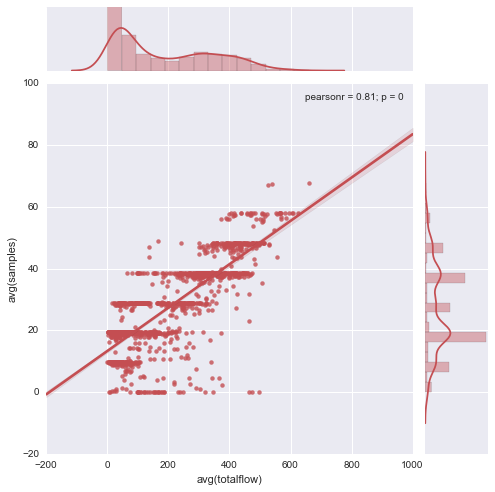

In [93]:
# precursor plot to see if a linear regression seems like it would be plausible for the data
sns.set(style="darkgrid", color_codes=True)

g = sns.jointplot("avg(totalflow)", "avg(samples)", data=merged_result_avg, kind="reg", color="r", size=7)

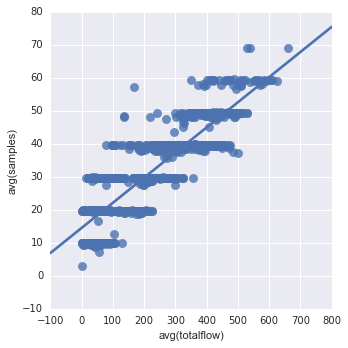

In [243]:
# using robust regression doesn't appear to give a different result for our dataset
sns.lmplot(x="avg(totalflow)", y="avg(samples)", data=merged_result_avg,
           robust=True, ci=None, scatter_kws={"s": 80});

# Determine feature importance
## Step1 convert categorical dimensions to numeric
## Step2 run through randomforest classifier to determine feature importance

In [401]:
# use label encoder to convert all non-numeric values into a numeric representation
clean_train = merged_result_avg_100.copy()
non_numeric = clean_train.columns.to_series().groupby(clean_train.dtypes).groups
print "non_numeric: %s" % non_numeric

# convert to categorical dimensions to numeric
number = LabelEncoder()
non_numeric_labels = {k.name: v for k, v in non_numeric.items()}['object']
for label in non_numeric_labels:
    clean_train[label] = number.fit_transform(clean_train[label].astype('str'))
non_numeric = clean_train.columns.to_series().groupby(clean_train.dtypes).groups
print "\nnon_numeric after clean: %s" % non_numeric

clean_train.head()

non_numeric: {dtype('O'): ['avg(lane8_avgspeed)', 'avg(lane8_flow)', 'Dir', 'State_PM', 'Type', 'Name', 'User_ID_2', 'User_ID_3', 'User_ID_4', 'file_date'], dtype('int64'): ['Station', '_c0', 'Unnamed: 0', 'Unnamed: 0.1', 'ID', 'Fwy', 'District', 'County', 'Lanes', 'User_ID_1'], dtype('float64'): ['avg(avgspeed)', 'avg(lane1_avgspeed)', 'avg(lane1_flow)', 'avg(lane2_avgspeed)', 'avg(lane2_flow)', 'avg(lane3_avgspeed)', 'avg(lane3_flow)', 'avg(lane4_avgspeed)', 'avg(lane4_flow)', 'avg(lane5_avgspeed)', 'avg(lane5_flow)', 'avg(lane6_avgspeed)', 'avg(lane6_flow)', 'avg(lane7_avgspeed)', 'avg(lane7_flow)', 'avg(perc_observed)', 'avg(samples)', 'avg(totalflow)', 'City', 'Abs_PM', 'Latitude', 'Longitude', 'Length', 'elevation']}

non_numeric after clean: {dtype('int64'): ['Station', 'avg(lane8_avgspeed)', 'avg(lane8_flow)', '_c0', 'Unnamed: 0', 'Unnamed: 0.1', 'ID', 'Fwy', 'Dir', 'District', 'County', 'State_PM', 'Type', 'Lanes', 'Name', 'User_ID_1', 'User_ID_2', 'User_ID_3', 'User_ID_4', 'f

,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),avg(lane4_avgspeed),avg(lane4_flow),...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,1108418,NaN,NaN,34.104241,NaN,8.051231,NaN,NaN,NaN,NaN,...,NaN,6,2,205,10512,0,0,0,9,46.761951
1,1108598,NaN,NaN,13.661365,NaN,15.291281,NaN,NaN,NaN,NaN,...,NaN,6,2,316,12602,0,0,0,9,183.335815
2,1114817,65.420123,70.247056,100.819969,67.068156,105.283492,63.908823,86.117006,58.945552,80.680488,...,0.303,5,4,698,3059,0,0,0,9,5.323312
3,1115517,66.718042,73.345410,75.098410,70.190123,89.131014,65.249489,107.169521,63.487130,121.113515,...,0.480,5,5,854,10309,0,0,0,9,7.147941
4,1120419,57.438984,57.438984,130.177665,NaN,NaN,NaN,NaN,NaN,NaN,...,2.841,4,1,718,43207,0,0,0,9,33.287594


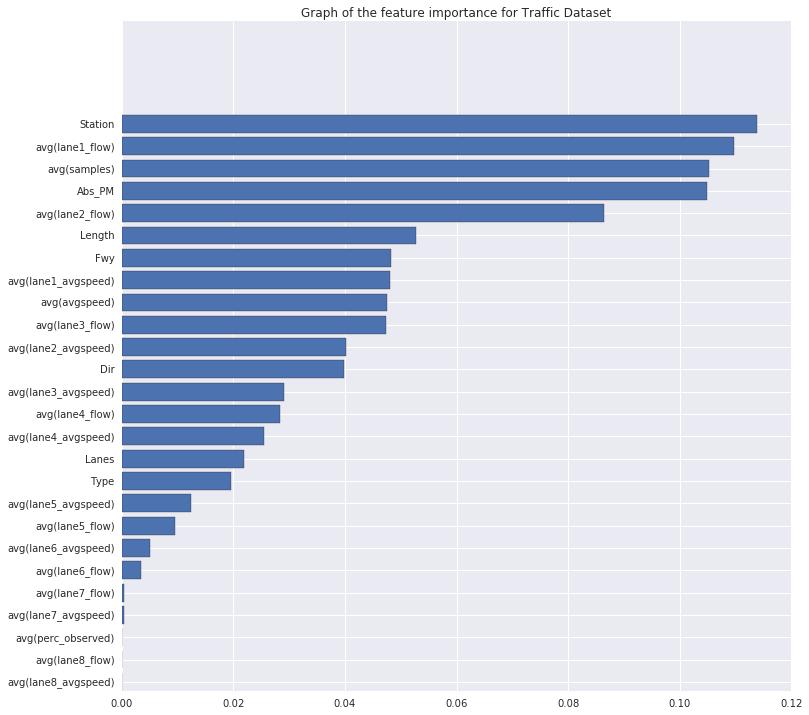

In [418]:
# determine the importance features
clean_train = clean_train.fillna(0)
for col in clean_train.columns:
    clean_train[col] = pd.to_numeric(clean_train[col])
    
y_100 = clean_train['avg(totalflow)']
train_columns = [u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'Fwy', u'Dir', u'Abs_PM',
       u'Length', u'Type', u'Lanes']
X_train, X_test, y_train, y_test = train_test_split(
    clean_train[train_columns], y_100, test_size=0.25, random_state=42)

model = sklearn.ensemble.RandomForestClassifier(random_state=42)

# model complained about having an unknown label until the conversion was done
y_train = np.asarray(y_train, dtype="|S6")
model.fit(X_train, y_train)
data = sorted(zip(train_columns, model.feature_importances_), key=lambda x: x[1])
data_arr = np.array(data)

index = np.arange(len(data_arr[:, 0]))
plt.figure(figsize=(12, 12))
ans = plt.barh(index, data_arr[:, 1])
ans = plt.yticks(index + .4, data_arr[:, 0])
ans = plt.title('Graph of the feature importance for Traffic Dataset')

From the chart above we can see that the Station, avg(lane1_flow), avg(samples), Abs_PM, and avg(lane2_flow) are the most important features. Now we can use this information to see which of these leads to the strongest model.

In [419]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

After some experimentation it was determined that the strongest, smallest combination of columns is:
avg(lane1_flow), avg(samples) and avg(lane2_flow)

In [498]:
columns = ['avg(lane1_flow)', 'avg(samples)', 'avg(lane2_flow)']

In [540]:
lr = linear_model.LinearRegression()
main_line_100 = merged_result_avg_100[merged_result_avg_100.Type == 'ML'].fillna(0)
y_100 = main_line_100['avg(totalflow)']
X_100 = main_line_100[columns]

# split the data between train and test
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(
    X_100, y_100, test_size=0.75, random_state=42)
model_100 = lr.fit(X_train_100, y_train_100)
predictions_100 = model_100.predict(X_test_100)
scores_100 = model_100.score(X_test_100, y_test_100)
scores_100

0.90849911794500238

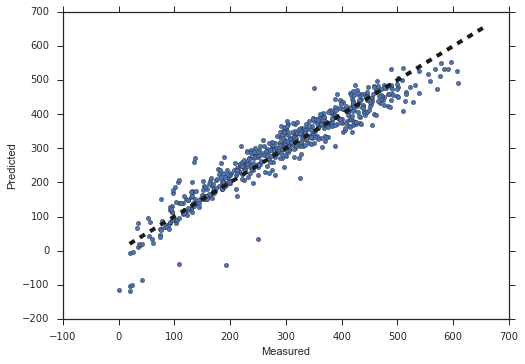

In [541]:
fig, ax = plt.subplots()
ax.scatter(y_test_100, predictions_100)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [542]:
# compare the same columns via a model including the imputed data by caltrans
lr = linear_model.LinearRegression()
main_line = merged_result_avg[merged_result_avg.Type == 'ML'].fillna(0)
y = main_line['avg(totalflow)']
X = main_line[columns]

# split the data between train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, random_state=42)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
scores = model.score(X_test, y_test)
scores

0.78576395808784083

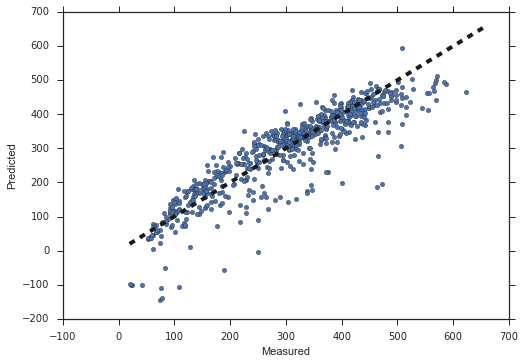

In [543]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Both models have an issue with predicting negative flow. Since negative flow makes no sense this will be adjusted to 0, if this is successful.

In [ ]:
# try to predict without using any flow components

In [652]:
columns = ['Abs_PM', 'avg(samples)', 'Length', 'Lanes', 'Fwy', 'Station', 'elevation']

In [659]:
lr = linear_model.LinearRegression()
main_line_100 = merged_result_avg_100[merged_result_avg_100.Type == 'ML'].fillna(0)
y_100 = main_line_100['avg(totalflow)']
X_100 = main_line_100[columns]

# split the data between train and test
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(
    X_100, y_100, test_size=0.75, random_state=42)
model_100 = lr.fit(X_train_100, y_train_100)
predictions_100 = model_100.predict(X_test_100)
scores_100 = model_100.score(X_test_100, y_test_100)
scores_100

0.73207957658625011

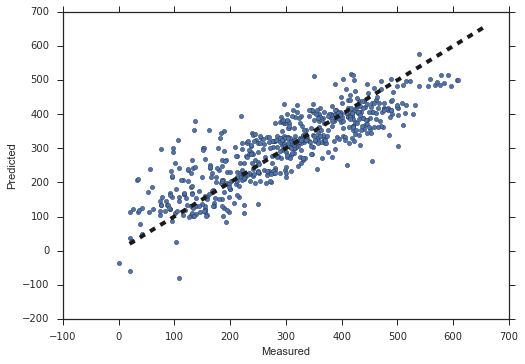

In [660]:
fig, ax = plt.subplots()
ax.scatter(y_test_100, predictions_100)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [664]:
# compare the model without imputed data to the imputed values
bad_main_line = merged_result_avg[(merged_result_avg['avg(perc_observed)'] == 0) & (merged_result_avg.Type == 'ML')][
    columns + ['avg(totalflow)']  #,  'Station']
]
bad_main_line

,Abs_PM,avg(samples),Length,Lanes,Fwy,Station,elevation,avg(totalflow)
126,27.478,0.000000,0.246,4,805,1123089,35.012482,246.693750
154,6.346,0.000000,0.290,2,125,1119060,170.259048,118.752166
216,23.501,0.000000,0.637,6,805,1126156,75.755173,495.554492
281,11.364,0.000000,0.260,2,125,1119179,93.163689,157.256773
313,4.067,0.000000,0.214,2,125,1119059,180.948593,119.967405
350,7.885,0.000000,0.452,2,56,1113072,178.243729,167.583551
373,5.428,19.340531,0.748,2,125,1119042,169.974411,122.353184
446,8.930,0.000000,0.714,3,52,1122781,137.538620,177.296979
447,1.829,0.000000,0.295,3,15,1122942,21.699638,236.310249
494,9.277,0.000000,0.382,2,56,1122991,185.011444,165.021042


In [668]:
# avg_flow = main_line_100['avg(totalflow)'].mean()
bad_line_input = bad_main_line[columns].fillna(0)
# print bad_line_input.shape
# print X_train_100.shape
predict_bad_100 = model_100.predict(bad_line_input)
# predict_bad = model.predict(bad_line_input)

In [669]:
print predictions_100[0:5]
print predictions[0:5]
print bad_main_line[['avg(totalflow)']][0:5]

[ 341.04052583  120.97876233  379.05388212  391.34109005  251.48955893]
[ 380.65837116  148.31787707  253.03817948  349.93413468  285.82779137]
     avg(totalflow)
126      246.693750
154      118.752166
216      495.554492
281      157.256773
313      119.967405


In [670]:
bad_main_line.head()

,Abs_PM,avg(samples),Length,Lanes,Fwy,Station,elevation,avg(totalflow)
126,27.478,0.0,0.246,4,805,1123089,35.012482,246.693750
154,6.346,0.0,0.290,2,125,1119060,170.259048,118.752166
216,23.501,0.0,0.637,6,805,1126156,75.755173,495.554492
281,11.364,0.0,0.260,2,125,1119179,93.163689,157.256773
313,4.067,0.0,0.214,2,125,1119059,180.948593,119.967405


In [671]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

## Test new imputed approach

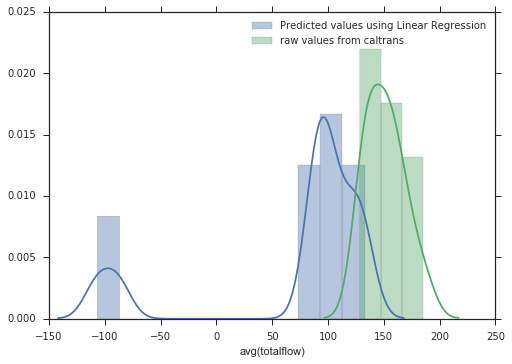

In [672]:
# Let's look at just the W_56
verify_56 = merged_result_avg[
    (merged_result_avg.Type == 'ML') & (merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56)][columns]
raw_56 = merged_result_avg[
    (merged_result_avg.Type == 'ML') & (merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56)][
    ['avg(totalflow)']]
predict_with_imputed = model_100.predict(verify_56)
to_plot = pd.Series(predict_with_imputed, name='avg(totalflow)')
ax = sns.distplot(to_plot, label='Predicted values using Linear Regression')
ax = sns.distplot(raw_56, ax=ax, label='raw values from caltrans')
plt.legend()

In [673]:
merged_result_avg.columns

Index([u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

In [675]:
W_56 = merged_result_avg_100[
    (merged_result_avg_100.Type == 'ML') & (merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56)]
W_56[['Station', 'Abs_PM', 'avg(perc_observed)', 'avg(totalflow)'] + columns].sort_values(
    by='Abs_PM')

,Station,avg(perc_observed),avg(totalflow),Abs_PM,avg(samples),Length,Lanes,Fwy,Station,elevation
845,1108743,100.0,169.793903,0.881,19.752777,1.371,2,56,1108743,21.134991
155,1108745,100.0,149.996062,1.861,19.750775,1.014,2,56,1108745,31.866579
1343,1113720,100.0,139.494396,2.909,19.754950,0.665,2,56,1113720,57.094433
882,1113771,100.0,154.590137,4.519,19.745703,1.379,2,56,1113771,91.343338
874,1113760,100.0,130.273411,5.948,19.754806,0.828,2,56,1113760,118.065025
665,1125219,100.0,129.411061,6.175,19.756935,0.856,2,56,1125219,120.941086
214,1125575,100.0,125.649981,7.661,19.755641,1.195,2,56,1125575,168.721405
849,1125546,100.0,138.233397,8.565,19.756190,0.820,2,56,1125546,170.239899
98,1125531,100.0,158.144638,9.302,19.752533,0.903,2,56,1125531,184.358032


In [676]:
W_56 = merged_result_avg_100[
    (merged_result_avg_100.Type == 'ML') & (merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56)]
W_56_model = model_100.fit(W_56[columns], W_56['avg(totalflow)'])
W_56[columns + ['avg(totalflow)', 'Station', 'Abs_PM']].sort_values(by='Abs_PM')

,Abs_PM,avg(samples),Length,Lanes,Fwy,Station,elevation,avg(totalflow),Station
845,0.881,19.752777,1.371,2,56,1108743,21.134991,169.793903,1108743
155,1.861,19.750775,1.014,2,56,1108745,31.866579,149.996062,1108745
1343,2.909,19.754950,0.665,2,56,1113720,57.094433,139.494396,1113720
882,4.519,19.745703,1.379,2,56,1113771,91.343338,154.590137,1113771
874,5.948,19.754806,0.828,2,56,1113760,118.065025,130.273411,1113760
665,6.175,19.756935,0.856,2,56,1125219,120.941086,129.411061,1125219
214,7.661,19.755641,1.195,2,56,1125575,168.721405,125.649981,1125575
849,8.565,19.756190,0.820,2,56,1125546,170.239899,138.233397,1125546
98,9.302,19.752533,0.903,2,56,1125531,184.358032,158.144638,1125531


In [682]:
bad_values = merged_result_avg[
    (merged_result_avg.Type == 'ML') & (merged_result_avg.Dir == 'W') & (merged_result_avg.Fwy == 56) &
    (merged_result_avg['avg(perc_observed)'] <= 90)]
bad_values = bad_values[['Station', 'Abs_PM', 'avg(perc_observed)', 'avg(totalflow)'] + columns].sort_values(
    by='Abs_PM')
bad_values

,avg(perc_observed),avg(totalflow),Abs_PM,avg(samples),Length,Lanes,Fwy,Station,elevation
780,48.928085,151.770741,3.190,19.333715,0.804,2,56,1125631,52.481609
962,89.445245,133.725991,5.948,17.946276,0.828,2,56,1113760,118.065025
350,0.000000,167.583551,7.885,0.000000,0.452,2,56,1113072,178.243729
904,0.000000,185.492642,9.712,0.000000,0.330,2,56,1122983,167.759033


In [683]:
columns

['Abs_PM', 'avg(samples)', 'Length', 'Lanes', 'Fwy', 'Station', 'elevation']

In [684]:
predictions = W_56_model.predict(bad_values[columns])

raw_56 = W_56[['avg(totalflow)', 'avg(samples)', 'avg(perc_observed)', 'Station', 'Abs_PM']]
bad_values.index = range(0, len(bad_values))
pd.concat([raw_56, pd.DataFrame({'predicted': W_56_predict})], axis=1)

,avg(perc_observed),avg(totalflow),Abs_PM,avg(samples),Length,Lanes,Fwy,Station,elevation,predicted
0,48.928085,151.770741,3.190,19.333715,0.804,2,56,1125631,52.481609,233.733964
1,89.445245,133.725991,5.948,17.946276,0.828,2,56,1113760,118.065025,493.331339
2,0.000000,167.583551,7.885,0.000000,0.452,2,56,1113072,178.243729,3962.004081
3,0.000000,185.492642,9.712,0.000000,0.330,2,56,1122983,167.759033,4020.347579


## Imputed calc results
As we can see the results are the same as what has been provided by caltrans. So we haven't improved the dataset.

# Density
Since the analysis of the flow through the freeway system didn't yield better results than what caltrans imputed data, let's try Density instead. The hope is that density will be superior because of the focus on using the distance between stations which should change the affect for stations that are close together as opposed to far apart since the distance will be used. Perhaps using this calculated form will lend itself to greater understanding or can be 
used as a calculated feature for linear regression.

Density = AbsDist * Flow / (Speed / 12)
Since Speed is in Miles per hour and Flow is vehciles per 5 min, we need to normalize the units

## Start with 56 W

In [578]:
lane_density_columns = []
for lane in range(1, 9):
    lane_density_columns.append('lane%sDensity' % lane)
lane_density_columns

['lane1Density',
 'lane2Density',
 'lane3Density',
 'lane4Density',
 'lane5Density',
 'lane6Density',
 'lane7Density',
 'lane8Density']

In [592]:
W56 = merged_result_avg_100[(merged_result_avg_100.Dir == 'W') & (merged_result_avg_100.Fwy == 56) &
                            (merged_result_avg_100.Type == 'ML')]
merged_columns = [u'Station', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)', u'avg(perc_observed)', 'avg(avgspeed)',
       u'avg(samples)', u'avg(totalflow)', u'Fwy', u'Dir', u'Abs_PM', u'Latitude', u'Longitude', u'Length',
       u'Type', u'Lanes', u'Name']
merged_data = pd.merge(W56[merged_columns], freeway_vectors['56_W'][['ID', 'order', 'distance']],
                       how='left', left_on='Station', right_on='ID')
merged_data['totalDensity'] = (merged_data['distance'] * merged_data['avg(totalflow)']) / merged_data['avg(avgspeed)']
for lane in range(1, 9):
    speed_key = 'avg(lane%s_avgspeed)' % lane
    flow_key = 'avg(lane%s_flow)' % lane
    density_key = 'lane%sDensity' % lane
    if not all(merged_data[speed_key].isnull()):
        merged_data[density_key] = ((merged_data['distance'] * merged_data[flow_key])
                                                / merged_data[speed_key])
    else:
        merged_data[density_key] = pd.Series([np.nan] * len(merged_data))
merged_data[['Station', 'order', 'totalDensity', 'lane1Density', 'lane2Density', 'lane3Density', 'lane4Density',
             'lane5Density', 'lane6Density', 'lane7Density', 'lane8Density']].sort_values(by='order')

,Station,order,totalDensity,lane1Density,lane2Density,lane3Density,lane4Density,lane5Density,lane6Density,lane7Density,lane8Density
4,1108743,0,2.406845,0.925248,1.479397,NaN,NaN,NaN,NaN,NaN,NaN
1,1108745,1,2.335829,1.093625,1.241806,NaN,NaN,NaN,NaN,NaN,NaN
8,1113720,2,2.347812,1.119627,1.226268,NaN,NaN,NaN,NaN,NaN,NaN
7,1113771,4,3.280595,1.613190,1.666913,NaN,NaN,NaN,NaN,NaN,NaN
6,1113760,5,2.935464,1.488248,1.447394,NaN,NaN,NaN,NaN,NaN,NaN
3,1125219,6,0.456556,0.231125,0.225371,NaN,NaN,NaN,NaN,NaN,NaN
2,1125575,7,2.887269,1.400899,1.487488,NaN,NaN,NaN,NaN,NaN,NaN
5,1125546,9,1.456507,0.670592,0.786902,NaN,NaN,NaN,NaN,NaN,NaN
0,1125531,10,1.854467,0.725750,1.127823,NaN,NaN,NaN,NaN,NaN,NaN


## Density Scale up to all Freeway

In [600]:
# scale density to all freeways
freeway_density = []
for freeway_key in freeway_vectors:
    fwy_num, fwy_dir = freeway_key.split('_')
    freeway_data = merged_result_avg_100[(merged_result_avg_100.Dir == fwy_dir) & 
                                         (merged_result_avg_100.Fwy == int(fwy_num)) &
                                         (merged_result_avg_100.Type == 'ML')]
    merged_columns = [u'Station', u'avg(lane1_avgspeed)',
           u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
           u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
           u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
           u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
           u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)', u'avg(perc_observed)', 'avg(avgspeed)',
           u'avg(samples)', u'avg(totalflow)', u'Fwy', u'Dir', u'Abs_PM', u'Latitude', u'Longitude', u'Length',
           u'Type', u'Lanes', u'Name']
    merged_data = pd.merge(freeway_data[merged_columns], freeway_vectors[freeway_key][['ID', 'order', 'distance']],
                           how='left', left_on='Station', right_on='ID')
    merged_data['totalDensity'] = ((merged_data['distance'] * merged_data['avg(totalflow)']) / 
                                   merged_data['avg(avgspeed)'])
    for lane in range(1, 9):
        speed_key = 'avg(lane%s_avgspeed)' % lane
        flow_key = 'avg(lane%s_flow)' % lane
        density_key = 'lane%sDensity' % lane
        if not all(merged_data[speed_key].isnull()):
            merged_data[density_key] = ((merged_data['distance'] * merged_data[flow_key])
                                                    / merged_data[speed_key])
        else:
            merged_data[density_key] = pd.Series([np.nan] * len(merged_data))
    freeway_density.append(merged_data[['Station', 'Fwy', 'Dir', 'Lanes', 'order', 'totalDensity', 'lane1Density',
                                        'lane2Density', 'lane3Density', 'lane4Density', 'lane5Density',
                                        'lane6Density', 'lane7Density', 'lane8Density']
                                      ].sort_values(by='order'))    

In [603]:
density_results = pd.concat(freeway_density).sort_values(by=['Fwy', 'Dir', 'order'])

In [623]:
merge_columns = [u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(samples)', u'avg(totalflow)', u'Type',
       u'avg(perc_observed)', u'Abs_PM', u'Length']
merged_result_avg_100_plus_density = pd.merge(density_results, merged_result_avg_100[merge_columns],
                                              how='inner', left_on='Station', right_on='Station')

## Review Important features

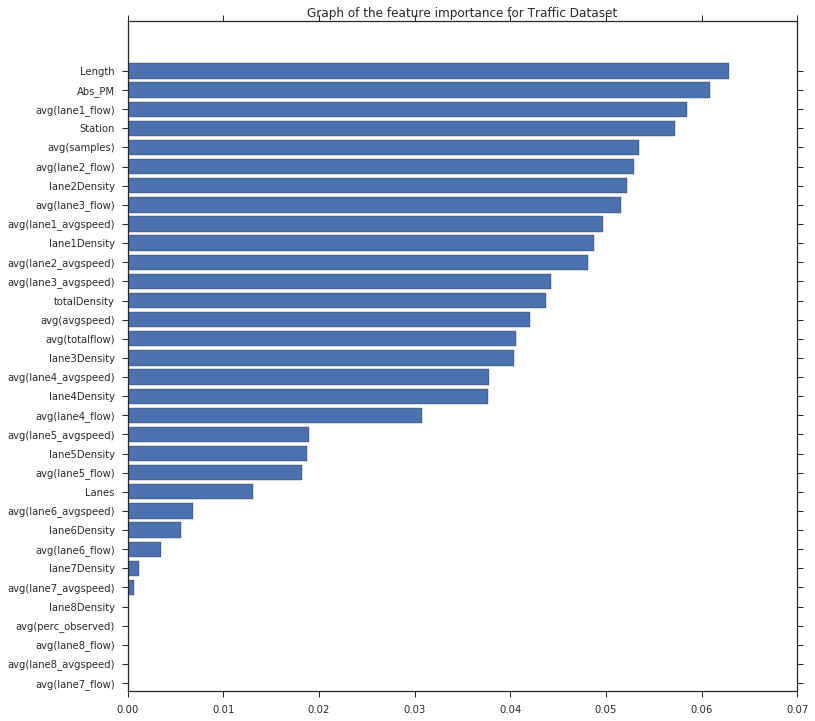

In [631]:
# determine the importance features
density_train_columns = lane_density_columns + ['totalDensity']
train_columns = [u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'Abs_PM',
       u'Length', u'Lanes'] + density_train_columns + ['avg(totalflow)']

clean_train = merged_result_avg_100_plus_density[train_columns].fillna(0)
for col in clean_train.columns:
    clean_train[col] = pd.to_numeric(clean_train[col])
    
y_100 = clean_train['avg(totalflow)']
X_train, X_test, y_train, y_test = train_test_split(
    clean_train[train_columns], y_100, test_size=0.25, random_state=42)

model = sklearn.ensemble.RandomForestClassifier(random_state=42)

# model complained about having an unknown label until the conversion was done
y_train = np.asarray(y_train, dtype="|S6")
model.fit(X_train, y_train)
data = sorted(zip(train_columns, model.feature_importances_), key=lambda x: x[1])
data_arr = np.array(data)

index = np.arange(len(data_arr[:, 0]))
plt.figure(figsize=(12, 12))
ans = plt.barh(index, data_arr[:, 1])
ans = plt.yticks(index + .4, data_arr[:, 0])
ans = plt.title('Graph of the feature importance for Traffic Dataset including Density')

In [542]:
# compare the same columns via a model including the imputed data by caltrans
lr = linear_model.LinearRegression()
main_line = merged_result_avg_100_plus_density[merged_result_avg_100_plus_density.Type == 'ML'].fillna(0)
y = main_line['avg(totalflow)']
X = main_line[columns]

# split the data between train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, random_state=42)
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)
scores = model.score(X_test, y_test)
scores

0.78576395808784083

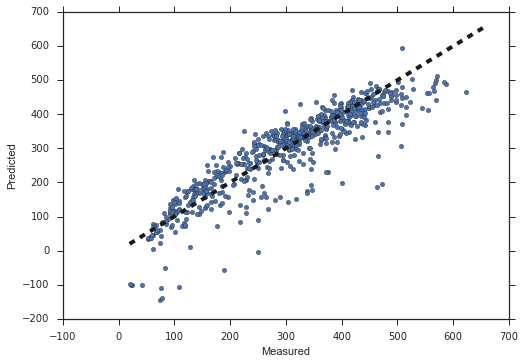

In [543]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# Outlier Detection

## Isolation Forest
For outlier detection we're using an isolation forest. 

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeable shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.
[1]	Liu, Fei Tony, Ting, Kai Ming and Zhou, Zhi-Hua. “Isolation forest.” Data Mining, 2008. ICDM‘08. Eighth IEEE International Conference on.
Source: http://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html

In [122]:
train_columns = [u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'Type', u'Lanes']
predict_column = ['avg(totalflow)']
total_columns = train_columns + predict_column + ['Station']

In [123]:
rng = np.random.RandomState(42)

In [124]:
# train data == 100% observed
train_data = merged_result_avg_100[(merged_result_avg_100['avg(perc_observed)'] == 100) &
                                   (merged_result_avg_100.Type == 'ML')][total_columns]
clean_train = train_data.copy()
non_numeric = clean_train.columns.to_series().groupby(clean_train.dtypes).groups
# print "non_numeric: %s" % non_numeric

# convert to categorical dimensions to numeric
number = LabelEncoder()
non_numeric_labels = {k.name: v for k, v in non_numeric.items()}['object']
for label in non_numeric_labels:
    clean_train[label] = number.fit_transform(clean_train[label].astype('str'))
non_numeric = clean_train.columns.to_series().groupby(clean_train.dtypes).groups
# print "\nnon_numeric after clean: %s" % non_numeric

clean_train = clean_train.fillna(0)
for col in clean_train.columns:
    clean_train[col] = pd.to_numeric(clean_train[col])

In [125]:
# test data == bad data
test_data = merged_result_avg[(merged_result_avg['avg(perc_observed)'] != 100) &
                              (merged_result_avg.Type == 'ML')][total_columns]

clean_test = test_data.copy()
non_numeric = clean_test.columns.to_series().groupby(clean_test.dtypes).groups
# print "non_numeric: %s" % non_numeric

# convert to categorical dimensions to numeric
number = LabelEncoder()
non_numeric_labels = {k.name: v for k, v in non_numeric.items()}['object']
for label in non_numeric_labels:
    clean_test[label] = number.fit_transform(clean_test[label].astype('str'))
non_numeric = clean_test.columns.to_series().groupby(clean_test.dtypes).groups
# print "\nnon_numeric after clean: %s" % non_numeric

clean_test = clean_test.fillna(0)
for col in clean_test.columns:
    clean_test[col] = pd.to_numeric(clean_test[col])

In [126]:
# Generate some abnormal novel observations
# fit the model
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(clean_train[train_columns], clean_train[predict_column])
y_pred_train = clf.predict(clean_train[train_columns])
y_pred_test = clf.predict(clean_test[train_columns])

outlier_index = [True if i == -1 else False for i in y_pred_test]
# print len(y_pred_test)
# print len(outlier_index)

counter = 0
for i in outlier_index:
    if i:
        counter += 1

## Visualize the Isolation Forest

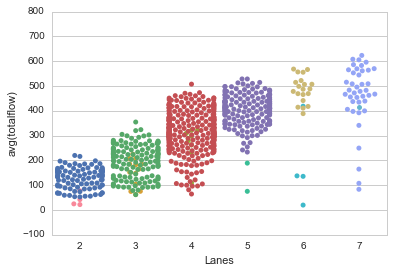

In [127]:
ret = sns.swarmplot(x="Lanes", y="avg(totalflow)", data=clean_test[outlier_index])
good_index = [not i for i in outlier_index]
sns.swarmplot(x="Lanes", y="avg(totalflow)", data=clean_test[good_index], ax=ret)

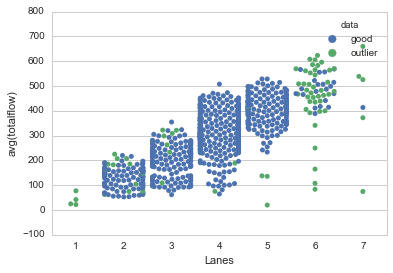

In [128]:
clean_test.set_value(outlier_index, 'data', 'outlier')
clean_test.set_value(good_index, 'data', 'good')

ret = sns.swarmplot(x="Lanes", y="avg(totalflow)", data=clean_test, hue='data')

## Review Raw Outlier Data

In [135]:
outlier_df = pd.merge(merged_result_avg, test_data[outlier_index][['Station']], how='right', on='Station')

In [146]:
review_columns = [u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
                  u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
                  u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)',
                  u'Fwy', u'Dir', u'Abs_PM', 'Lanes', 'Type']

In [147]:
outlier_df[(outlier_df.Fwy == 56) & (outlier_df.Dir == 'W')][review_columns].T

,46
Station,1122983
avg(avgspeed),60.8385
avg(lane1_avgspeed),62.2582
avg(lane1_flow),88.2599
avg(lane2_avgspeed),59.6062
avg(lane2_flow),97.2327
avg(perc_observed),0
avg(samples),0
avg(totalflow),185.493
Fwy,56


In [148]:
W_56[(W_56.Fwy == 56) & (W_56.Dir == 'W')][review_columns].sort_values(by='Abs_PM').T

,987,887,929,170,1194,866,1466,149,1438,780,...,734,235,781,442,350,448,427,934,106,904
Station,1108744,1113615,1108743,1108745,1113609,1108746,1113720,1113723,1113721,1125631,...,1125219,1125575,1113683,1113073,1113072,1125548,1125543,1125546,1125531,1122983
avg(avgspeed),NaN,NaN,62.1476,62.9239,NaN,NaN,62.256,NaN,NaN,61.6484,...,64.3506,64.6533,NaN,NaN,62.8561,NaN,NaN,64.4164,62.7982,60.8385
avg(lane1_avgspeed),NaN,NaN,67.2041,66.628,NaN,NaN,65.6441,NaN,NaN,65.2559,...,67.447,68.0485,NaN,NaN,64.8767,NaN,NaN,67.9806,66.0149,62.2582
avg(lane1_flow),10.6905,16.438,70.6976,74.4096,11.7259,10.8501,70.1887,4.953,0.743673,68.5515,...,70.1695,65.834,NaN,NaN,82.1842,19.9157,31.6313,68.0139,65.2168,88.2599
avg(lane2_avgspeed),NaN,NaN,59.0757,59.6813,NaN,NaN,59.2598,NaN,NaN,58.9872,...,61.1826,61.3908,NaN,NaN,60.8816,NaN,NaN,61.3008,60.7687,59.6062
avg(lane2_flow),20.0734,NaN,99.2198,75.6313,NaN,25.5217,69.3457,13.6401,2.3721,83.2192,...,62.0973,62.7727,NaN,NaN,85.3994,NaN,NaN,71.9476,92.5484,97.2327
avg(perc_observed),97.7699,97.7699,97.7699,97.8508,48.9261,97.8521,97.8562,97.8562,97.8562,48.9281,...,94.0927,94.0024,0,0,0,93.8164,93.8164,93.8164,94.5589,0
avg(samples),19.3167,9.65835,19.3123,19.3263,19.3336,19.3336,19.3314,29.002,19.3346,19.3337,...,18.6635,18.6445,0,0,0,9.31015,9.31015,18.6168,18.7188,0
avg(totalflow),30.7639,16.438,169.917,150.041,11.7259,36.3718,139.534,35.8406,3.11578,151.771,...,132.267,128.607,NaN,NaN,167.584,19.9157,31.6313,139.961,157.765,185.493
Fwy,56,56,56,56,56,56,56,56,56,56,...,56,56,56,56,56,56,56,56,56,56


In [153]:
# source: http://stackoverflow.com/questions/28778668/freeze-header-in-pandas-dataframe
from ipywidgets import interact, IntSlider
from IPython.display import display

def freeze_header(df, num_rows=30, num_columns=10, step_rows=1,
                  step_columns=1):
    """
    Freeze the headers (column and index names) of a Pandas DataFrame. A widget
    enables to slide through the rows and columns.

    Parameters
    ----------
    df : Pandas DataFrame
        DataFrame to display
    num_rows : int, optional
        Number of rows to display
    num_columns : int, optional
        Number of columns to display
    step_rows : int, optional
        Step in the rows
    step_columns : int, optional
        Step in the columns

    Returns
    -------
    Displays the DataFrame with the widget
    """
    @interact(last_row=IntSlider(min=min(num_rows, df.shape[0]),
                                 max=df.shape[0],
                                 step=step_rows,
                                 description='rows',
                                 readout=False,
                                 disabled=False,
                                 continuous_update=True,
                                 orientation='horizontal',
                                 slider_color='purple'),
              last_column=IntSlider(min=min(num_columns, df.shape[1]),
                                    max=df.shape[1],
                                    step=step_columns,
                                    description='columns',
                                    readout=False,
                                    disabled=False,
                                    continuous_update=True,
                                    orientation='horizontal',
                                    slider_color='purple'))
    def _freeze_header(last_row, last_column):
        display(df.iloc[max(0, last_row-num_rows):last_row,
                        max(0, last_column-num_columns):last_column])

In [159]:
outlier_df[(outlier_df.Fwy == 56) & (outlier_df.Dir == 'E')][review_columns].T

,23
Station,1122991
avg(avgspeed),60.4009
avg(lane1_avgspeed),61.8747
avg(lane1_flow),77.1598
avg(lane2_avgspeed),59.1966
avg(lane2_flow),87.8612
avg(perc_observed),0
avg(samples),0
avg(totalflow),165.021
Fwy,56


In [161]:
df = merged_result_avg[(merged_result_avg.Fwy == 56) & (merged_result_avg.Dir == 'E') &
                       (merged_result_avg.Type == 'ML')][
    review_columns].sort_values(by='Abs_PM').T
freeze_header(df.T, step_columns=2)

,avg(lane2_avgspeed),avg(lane2_flow),avg(perc_observed),avg(samples),avg(totalflow),Fwy,Dir,Abs_PM,Lanes,Type
236,65.8382,45.0617,97.8548,28.9897,128.959,56,E,0.42,3,ML
679,63.1042,62.4542,97.7803,28.9707,165.887,56,E,0.966,3,ML
355,60.5076,75.9697,97.8521,19.3249,144.946,56,E,1.891,3,ML
297,60.7599,67.0028,48.9281,19.3334,139.255,56,E,2.909,2,ML
414,61.2831,67.6566,97.8555,19.3308,143.645,56,E,3.188,2,ML
1251,60.126,78.3645,85.611,17.6784,156.884,56,E,4.522,2,ML
1081,60.6427,67.0356,89.4452,17.9454,137.513,56,E,5.95,2,ML
713,61.573,67.1509,94.0927,18.6631,136.004,56,E,6.173,2,ML
745,64.2793,93.5774,0,0,232.724,56,E,7.364,3,ML
35,67.7457,57.9796,94.0024,27.961,138.118,56,E,8.173,3,ML


In [162]:
outlier_df[(outlier_df.Fwy == 5) & (outlier_df.Dir == 'N')][review_columns].T

,0,6,9,12,22,34,56,59,62
Station,1122528,1123135,1115289,1114276,1122575,1114091,1114847,1123331,1122552
avg(avgspeed),67.6738,63.0462,63.7479,64.9306,62.1046,65.6169,63.5398,68.1593,63.214
avg(lane1_avgspeed),72.7642,63.0462,69.4147,73.6993,NaN,75.0894,69.9004,68.1593,NaN
avg(lane1_flow),79.2884,21.8788,100.13,67.0252,NaN,10.389,87.4706,77.2681,NaN
avg(lane2_avgspeed),70.3727,NaN,67.5741,69.8933,66.5795,71.8559,66.4809,NaN,68.9287
avg(lane2_flow),78.3155,NaN,94.461,95.359,100.1,21.5428,101.016,NaN,98.5056
avg(perc_observed),63.3542,95.5816,96.4238,97.2269,97.8209,81.5475,0,0.204816,97.8198
avg(samples),38.8707,9.4222,57.5066,56.153,48.2964,49.0321,0,2.5329,48.2942
avg(totalflow),341.229,21.8788,466.598,569.438,434.943,164.911,462.421,77.2681,453.988
Fwy,5,5,5,5,5,5,5,5,5


In [163]:
df = merged_result_avg[(merged_result_avg.Fwy == 5) & (merged_result_avg.Dir == 'N') &
                       (merged_result_avg.Type == 'ML')][
    review_columns].sort_values(by='Abs_PM').T
freeze_header(df.T, step_columns=2)

,Station,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(perc_observed),avg(samples),avg(totalflow),Fwy
650,1114091,65.6169,75.0894,10.389,71.8559,21.5428,81.5475,49.0321,164.911,5
24,1118333,66.9434,73.3927,11.953,70.0751,20.181,88.9187,38.5878,81.5075,5
301,1114709,65.6222,72.1384,34.7508,69.8559,25.7182,85.6757,34.9806,144.73,5
932,1118348,67.2718,74.0585,10.4221,70.3301,28.4981,94.1846,38.6015,100.996,5
1187,1114720,66.4217,72.8724,42.8327,69.6079,40.9679,75.5282,30.9442,185.005,5
1411,1118352,66.719,74.4623,12.0967,70.1712,39.157,97.5806,38.6035,153.169,5
1321,1118743,63.4562,72.7592,41.8681,65.4653,72.1116,96.9035,38.351,294.864,5
261,1118379,67.4193,74.5387,24.7609,69.7237,68.916,97.7147,38.5869,208.528,5
1069,1114734,69.1718,75.3975,33.2303,71.2546,80.3092,94.8141,46.0739,315.643,5
223,1123135,63.0462,63.0462,21.8788,NaN,NaN,95.5816,9.4222,21.8788,5


Looks like the isolation forest didn't find only stations with poor health. In some cases healthy stations where found, which implies that these stations have an abnormal amount of something about them. 
## TODO: try dropping samples, and % observed and just train / calculate outlier on speed / flow

## TODO: need to discuss how to "fix" data points

In [ ]:
# data.printSchema()

collect data for on-ramp / off-ramp
Investigate the on-ramp / off-ramp data

Plot per lane the news paper clipping images from Josh's presentation
Speed over time
Flow over time

When synchronized the speed is same in all lanes
Look at the variance across all lanes for each lane
do visualization to variation / variance across the lanes
DOD: notebook with nbviewer format

In [ ]:
merged_result_avg_100, merged_result_avg_80, merged_result_avg_50, merged_result_avg

In [164]:
merged_result_avg_100.columns

Index([u'Unnamed: 0', u'Station', u'avg(avgspeed)', u'avg(lane1_avgspeed)',
       u'avg(lane1_flow)', u'avg(lane2_avgspeed)', u'avg(lane2_flow)',
       u'avg(lane3_avgspeed)', u'avg(lane3_flow)', u'avg(lane4_avgspeed)',
       u'avg(lane4_flow)', u'avg(lane5_avgspeed)', u'avg(lane5_flow)',
       u'avg(lane6_avgspeed)', u'avg(lane6_flow)', u'avg(lane7_avgspeed)',
       u'avg(lane7_flow)', u'avg(lane8_avgspeed)', u'avg(lane8_flow)',
       u'avg(perc_observed)', u'avg(samples)', u'avg(totalflow)', u'_c0',
       u'Unnamed: 0.1', u'Unnamed: 0.1', u'ID', u'Fwy', u'Dir', u'District',
       u'County', u'City', u'State_PM', u'Abs_PM', u'Latitude', u'Longitude',
       u'Length', u'Type', u'Lanes', u'Name', u'User_ID_1', u'User_ID_2',
       u'User_ID_3', u'User_ID_4', u'file_date', u'elevation'],
      dtype='object')

In [176]:
def select_freeway(direction='N', freeway=5, data=merged_result_avg, fwy_type='ML'):
    return data[(data.Fwy == freeway) & (data.Dir == direction) & (data.Type == fwy_type)]

In [178]:
play_data = select_freeway()
data_to_merge = {}
for idx in range(1, 9):
    col = 'avg(lane%s_avgspeed)' % idx
    data_to_merge['lane%s' % idx] = play_data[col]
df = pd.concat(data_to_merge, axis=1)
df.head()

,lane1,lane2,lane3,lane4,lane5,lane6,lane7,lane8
2,70.151589,66.975464,63.796920,58.904669,NaN,NaN,NaN,NaN
7,72.764161,70.372703,67.380747,65.564053,62.457808,63.16129,NaN,NaN
22,69.836494,66.470516,60.898077,58.873722,NaN,NaN,NaN,NaN
24,73.392676,70.075120,66.539746,61.723294,NaN,NaN,NaN,NaN
27,70.117345,65.505833,62.452498,58.374261,NaN,NaN,NaN,NaN


In [167]:
sns.lmplot(x='')

In [171]:
pd.merge?